In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:124: SyntaxWarning: invalid escape sequence '\D'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:124: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\1473689655.py:90: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title(f"HODL vs Rebalanced vs LP, with $\mu = ${mu}, $\sigma = ${sigma}")
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\1473689655.py:90: SyntaxWarning: invalid escape sequence '\s'
  ax[0].set_title(f"HODL vs Rebalanced vs LP, with $\mu = ${mu}, $\sigma = ${sigma}")
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\1473689655.py:124: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\1473689655.py:92: UserWarning: No artists with labels found to put

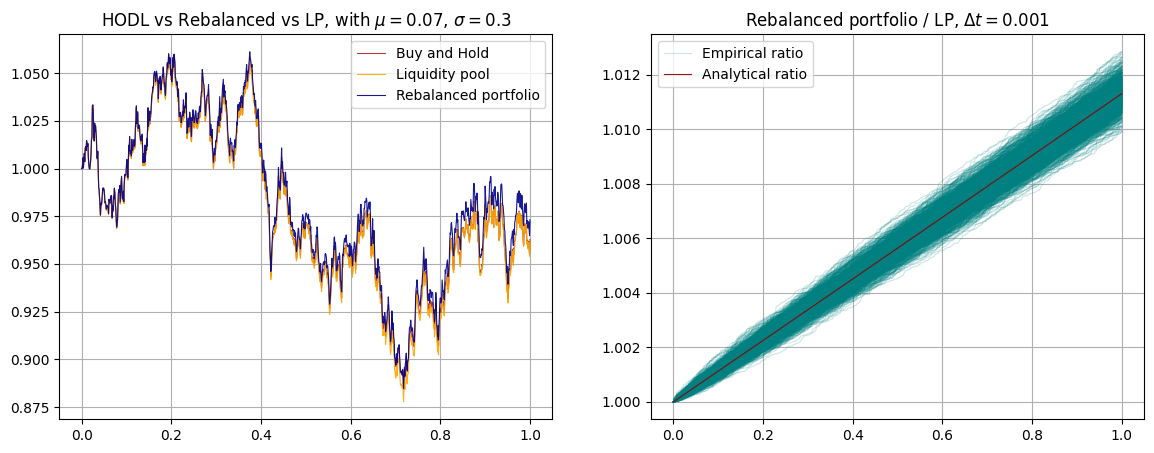

In [2]:
dt = 0.001
T = 1
t_array = np.arange(0, T+dt, dt)

mu = 0.07
sigma = 0.3
S_0 = 100

def simulate_gbm_OLD(mu, sigma, dt=0.01, T=1, S_0=100):
    t_array = np.arange(0, T+dt, dt)
    z_rand = np.random.normal(loc=0, scale=1, size=len(t_array))
    wienner_process = z_rand.cumsum()
    drift_arr = np.full(fill_value=(mu - np.pow(sigma, 2)/2)*dt, shape=len(t_array)).cumsum()

    gbm = S_0*np.exp(drift_arr + sigma*wienner_process)
    return gbm


def simulate_gbm(mu, sigma, t_array=None, dt=0.01, T=1, S_0=100):
    """
    Simulate a single path of Geometric Brownian Motion (GBM).

    Parameters
    ----------
    mu : float
        Drift coefficient (expected return)
    sigma : float
        Volatility coefficient
    t_array : array-like or None
        Optional. If provided, time points at which to simulate GBM.
        If None, generates np.arange(0, T + dt, dt).
    dt : float
        Time step size
    T : float
        Total simulation time
    S_0 : float
        Initial value (e.g., starting stock price)

    Returns
    -------
    t : np.ndarray
        Time array from 0 to T
    S : np.ndarray
        Simulated GBM values corresponding to t
    """

    # Use provided t_array or generate one
    if t_array is None:
        t_array = np.arange(0, T + dt, dt)
    else:
        dt = np.diff(t_array).mean()

    n_steps = len(t_array)
    # Generate random normal increments for Brownian motion
    dW = np.random.normal(0, np.sqrt(dt), size=n_steps - 1)
    W = np.concatenate(([0], np.cumsum(dW)))

    # Analytical GBM solution
    S = S_0 * np.exp((mu - 0.5 * sigma**2) * t_array + sigma * W)

    return S


c = 100
w_1 = 0.5
w_0 = 1 - w_1

N = 1000
gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
gbm_matrix = np.vstack(gbms).T
gbm_matrix = gbm_matrix / gbm_matrix[0]

# Simulating buy and hold
buy_n_hold_matrix = w_1*gbm_matrix + w_0*gbm_matrix[0]
buy_n_hold_matrix = buy_n_hold_matrix / buy_n_hold_matrix[0]

linewidth = 0.8
alpha = 0.9
alpha_low = 0.2

color_lp = 'orange'
color_rebalance = 'darkblue'
color_buy_n_hold = 'brown'

color_3 = 'teal'
color_4 = 'darkred'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax[0].set_title(f"HODL vs Rebalanced vs LP, with $\mu = ${mu}, $\sigma = ${sigma}")
ax[0].grid(True)
ax[0].legend()

for i in range(buy_n_hold_matrix.shape[1]-1):
    buy_n_hold = buy_n_hold_matrix[:, i]
    ######ax[0].plot(t_array, buy_n_hold, color=color_buy_n_hold, alpha=alpha, linewidth=linewidth)
ax[0].plot(t_array, buy_n_hold_matrix[:, -1], color=color_buy_n_hold, alpha=alpha, linewidth=linewidth, label='Buy and Hold')
#plt.hlines(y=1+np.log(gbms[-1][-1]/gbms[-1][0]), xmin=0, xmax=T)

s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
s_matrix = s_matrix / s_matrix[0]

for i in range(s_matrix.shape[1]-1):
    s = s_matrix[:, i]
    ######ax[0].plot(t_array, s, alpha=alpha, linewidth=linewidth, color=color_lp)
ax[0].plot(t_array, s_matrix[:, -1], alpha=alpha, linewidth=linewidth, color=color_lp, label='Liquidity pool')

gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

rebalance_matrix[1:] = rebalance_log_returns
rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
rebalance_matrix = np.exp(rebalance_matrix)
rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

for i in range(rebalance_matrix.shape[1]-1):
    X = rebalance_matrix[:, i]
    #####ax[0].plot(t_array, X, alpha=alpha, linewidth=linewidth, color=color_rebalance)
ax[0].plot(t_array, rebalance_matrix[:, -1], alpha=alpha, linewidth=linewidth, color=color_rebalance, label='Rebalanced portfolio')
ax[0].legend()

ax[1].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
diff_rebalance = rebalance_matrix / s_matrix
for i in range(rebalance_matrix.shape[1]-1):
    diff_arr = diff_rebalance[:, i]
    ax[1].plot(t_array, diff_arr, alpha=alpha_low, linewidth=linewidth, color=color_3)
ax[1].plot(t_array, diff_rebalance[:, -1], alpha=alpha_low, linewidth=linewidth, color=color_3, label=f'Empirical ratio')

#diff_rebalance_mean = np.mean(diff_rebalance, axis=1)
#plt.plot(t_array, diff_rebalance_mean, color=color_3, label='Mean value', alpha=0.3)

ax[1].plot(t_array, np.exp(sigma**2*t_array/8), color=color_4, label='Analytical ratio', linewidth=linewidth, alpha=alpha)
ax[1].legend()
ax[1].grid(True)

<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:117: SyntaxWarning: invalid escape sequence '\l'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:117: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\873983568.py:108: SyntaxWarning: invalid escape sequence '\D'
  ax[ax_idx].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\873983568.py:117: SyntaxWarning: invalid escape sequence '\l'
  ax[ax_idx].plot(t_array, np.exp(sigma**2*t_array/8), color=color_4, label='Analytical ratio $e^{\lambda t}$', linewidth=linewidth, alpha=alpha)


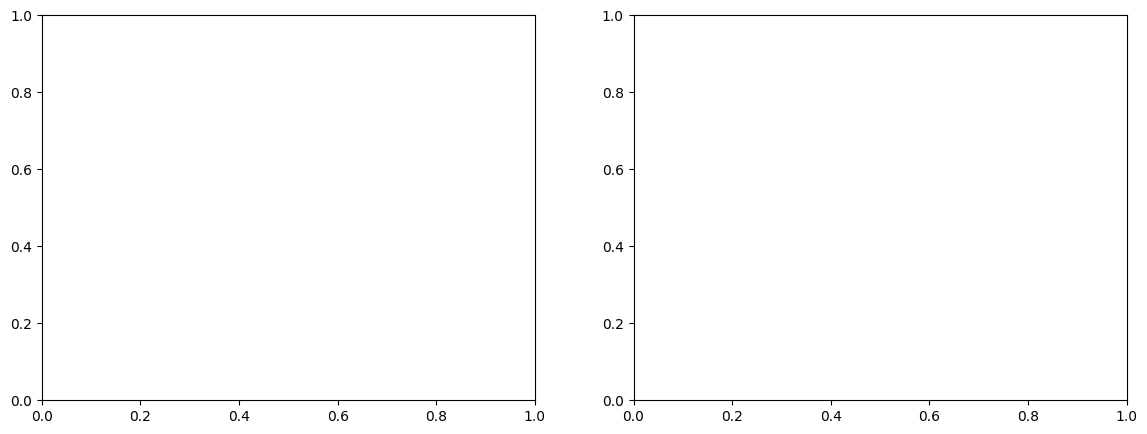

In [3]:
dt = 0.001
T = 1
t_array = np.arange(0, T+dt, dt)

mu = 0.07
sigma = 0.3
S_0 = 100

def simulate_gbm(mu, sigma, t_array=None, dt=0.01, T=1, S_0=100):
    """
    Simulate a single path of Geometric Brownian Motion (GBM).

    Parameters
    ----------
    mu : float
        Drift coefficient (expected return)
    sigma : float
        Volatility coefficient
    t_array : array-like or None
        Optional. If provided, time points at which to simulate GBM.
        If None, generates np.arange(0, T + dt, dt).
    dt : float
        Time step size
    T : float
        Total simulation time
    S_0 : float
        Initial value (e.g., starting stock price)

    Returns
    -------
    t : np.ndarray
        Time array from 0 to T
    S : np.ndarray
        Simulated GBM values corresponding to t
    """

    # Use provided t_array or generate one
    if t_array is None:
        t_array = np.arange(0, T + dt, dt)
    else:
        dt = np.diff(t_array).mean()

    n_steps = len(t_array)
    # Generate random normal increments for Brownian motion
    dW = np.random.normal(0, np.sqrt(dt), size=n_steps - 1)
    W = np.concatenate(([0], np.cumsum(dW)))

    # Analytical GBM solution
    S = S_0 * np.exp((mu - 0.5 * sigma**2) * t_array + sigma * W)

    return S


c = 100
w_1 = 0.5
w_0 = 1 - w_1

N = 1000
gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
gbm_matrix = np.vstack(gbms).T
gbm_matrix = gbm_matrix / gbm_matrix[0]

s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
s_matrix = s_matrix / s_matrix[0]

linewidth = 0.8
alpha = 0.9
alpha_low = 0.2

color_lp = 'orange'
color_rebalance = 'darkblue'
color_buy_n_hold = 'brown'

color_3 = 'teal'
color_4 = 'darkred'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

rebalance_matrix[1:] = rebalance_log_returns
rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
rebalance_matrix = np.exp(rebalance_matrix)
rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

def plot_sim(dt, ax_idx):
    t_array = np.arange(0, T+dt, dt)
    gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
    gbm_matrix = np.vstack(gbms).T
    gbm_matrix = gbm_matrix / gbm_matrix[0]

    s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
    s_matrix = s_matrix / s_matrix[0]

    gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
    rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

    rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

    rebalance_matrix[1:] = rebalance_log_returns
    rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
    rebalance_matrix = np.exp(rebalance_matrix)
    rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

    ax[ax_idx].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
    diff_rebalance = rebalance_matrix / s_matrix
    for i in range(rebalance_matrix.shape[1]-1):
        diff_arr = diff_rebalance[:, i]
        ax[ax_idx].plot(t_array, diff_arr, alpha=alpha_low, linewidth=linewidth, color=color_3)
    ax[ax_idx].plot(t_array, diff_rebalance[:, -1], alpha=alpha_low, linewidth=linewidth, color=color_3, label=f'Empirical ratio')

    #diff_rebalance_mean = np.mean(diff_rebalance, axis=1)
    #plt.plot(t_array, diff_rebalance_mean, color=color_3, label='Mean value', alpha=0.3)
    ax[ax_idx].plot(t_array, np.exp(sigma**2*t_array/8), color=color_4, label='Analytical ratio $e^{\lambda t}$', linewidth=linewidth, alpha=alpha)
    ax[ax_idx].legend()
    ax[ax_idx].grid(True)
#plot_sim(dt=0.0001, ax_idx=0)
#plot_sim(dt=0.00001, ax_idx=1)

<>:84: SyntaxWarning: invalid escape sequence '\l'
<>:84: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\3146253946.py:84: SyntaxWarning: invalid escape sequence '\l'
  ax[1].plot(t_array_2, np.exp(l*x_array_2), linewidth=linewidth, alpha=alpha, color=color_4, label='Analytical ratio $e^{\lambda t}$')
C:\Users\jens2\AppData\Local\Temp\ipykernel_27812\3146253946.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers, start='2019-01-01', end='2020-01-01', multi_level_index=False)
[*********************100%***********************]  5 of 5 completed


Price          Close                               Cash
Ticker          AAPL BTC-USD ETH-USD   MSFT    USD     
Price Ticker                                           
Close AAPL     0.069  -0.021  -0.006  0.032  0.091  0.0
      BTC-USD -0.021   0.481   0.420 -0.011 -0.031  0.0
      ETH-USD -0.006   0.420   0.561  0.002 -0.012  0.0
      MSFT     0.032  -0.011   0.002  0.039  0.064  0.0
      USD      0.091  -0.031  -0.012  0.064  0.257  0.0
Cash           0.000   0.000   0.000  0.000  0.000  0.0
0.11720902619748783 0.034223002529912123
0.08298602366757571
Price  Ticker 
Close  AAPL        88.74
       BTC-USD     82.42
       ETH-USD    -16.41
       MSFT        58.26
       USD        106.19
Cash                0.00
dtype: float64


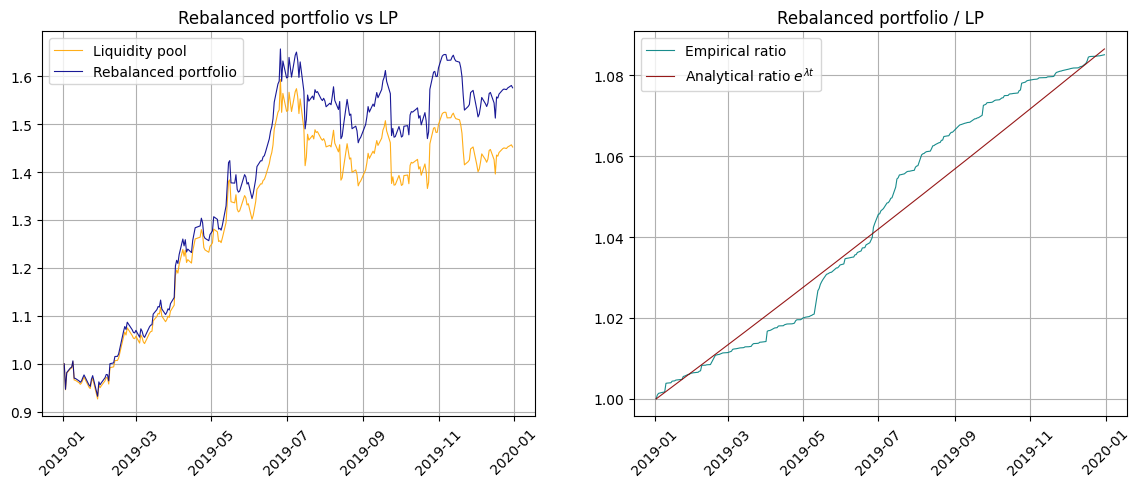

0.02979232290134215


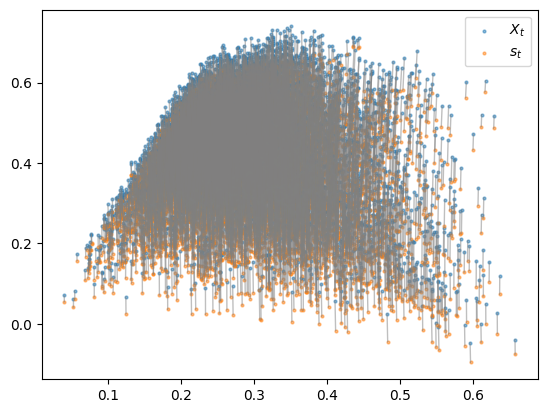

(array([  13.,  130.,  305.,  607., 1015., 1426., 2223., 2571., 1451.,
         259.]),
 array([0.00492777, 0.01513981, 0.02535185, 0.03556389, 0.04577592,
        0.05598796, 0.0662    , 0.07641204, 0.08662407, 0.09683611,
        0.10704815]),
 <BarContainer object of 10 artists>)

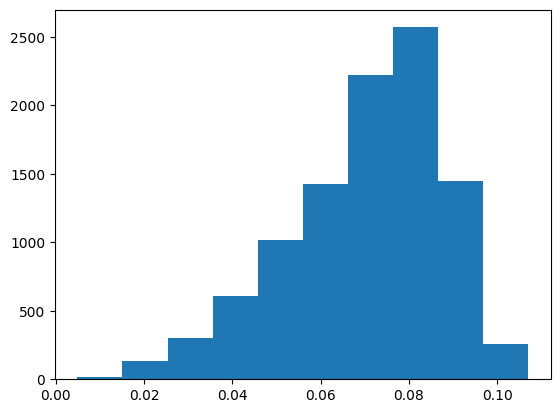

In [37]:
tickers = ['AAPL', 'MSFT', 'BTC-USD', 'ETH-USD', 'USD']
#tickers = ['CCL', 'NCLH', 'OXY', 'AAL']

# tickers = [
#     "JNJ",    # Johnson & Johnson – healthcare
#     "KO",     # Coca-Cola – beverages
#     "PEP",    # PepsiCo – beverages and snacks
#     "WMT",    # Walmart – retail
#     "CL",     # Colgate-Palmolive – personal care
#     "MDT",    # Medtronic – medical devices
#     "MCD"    # McDonald's – fast food
# ]

df = yf.download(tickers=tickers, start='2019-01-01', end='2020-01-01', multi_level_index=False)
#df = yf.download(tickers=tickers, interval='1m', period='7d')
df = df[['Close']]

df['Cash'] = 100
df = df.dropna()

N_assets = len(df.columns)
w_vector = np.ones(shape=N_assets) / N_assets

def get_lambda(df, w_vector):
    df_returns = df.pct_change().dropna() - 1
    cov_matrix = df_returns.cov().to_numpy() * 252
    print(np.round(252*df_returns.cov(), 3))

    a = np.dot(w_vector, np.diag(cov_matrix)) / 2
    b = w_vector @ cov_matrix @ w_vector.T / 2
    print(a, b)
    return a - b

l = get_lambda(df, w_vector)
print(l)

print(np.round(100*(df.iloc[-1] / df.iloc[0] - 1), 2))

def compute_st_value(df_prices, w_vector, s_0=1):
    data_np = df_prices.to_numpy()
    data_log_weighted = w_vector*np.log(data_np)
    y = np.exp(np.sum(data_log_weighted, axis=1))
    y = s_0 * (y / y[0])

    return y

def compute_Xt_value(df_prices, w_vector, X_0=1):
    data_np = df_prices.to_numpy()
    log_returns = np.log((data_np[1:] / data_np[:-1]) @ w_vector.T)
    rebalance_array = np.full(shape=data_np.shape[0],fill_value=np.log(X_0))

    rebalance_array[1:] = log_returns
    rebalance_value = np.cumsum(rebalance_array)
    rebalance_value = np.exp(rebalance_value)
    
    return rebalance_value

def compute_metrics(value, annualising_factor=252):
    returns = np.log(value[1:] / value[:-1])
    mean_return = np.mean(returns)

    avg_std = np.std(returns)
    return mean_return *annualising_factor, avg_std * np.sqrt(annualising_factor)

s_t = compute_st_value(df, w_vector, 1)
X_t = compute_Xt_value(df, w_vector, 1)

t_0 = df.index[0].timestamp()
t_1 = df.index[-1].timestamp()
t_array_2 = pd.date_range(start=df.index[0], end=df.index[-1], periods=1000)
x_array_2 = np.linspace(0, 1, len(t_array_2))

fix, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

for axi in ax.flat:
    axi.grid(True)  # Turn on grid

ax[0].plot(df.index, s_t, linewidth=linewidth, alpha=alpha, color=color_lp, label='Liquidity pool')
ax[0].plot(df.index, X_t, linewidth=linewidth, alpha=alpha, color=color_rebalance, label='Rebalanced portfolio')
ax[0].set_title("Rebalanced portfolio vs LP")
ax[0].legend()

ax[1].plot(df.index, X_t/s_t, linewidth=linewidth, alpha=alpha, color=color_3, label='Empirical ratio')
ax[1].plot(t_array_2, np.exp(l*x_array_2), linewidth=linewidth, alpha=alpha, color=color_4, label='Analytical ratio $e^{\lambda t}$')
ax[1].set_title("Rebalanced portfolio / LP")
ax[1].legend()
for axi in ax.flat:
    axi.tick_params(axis='x', labelrotation=45)
plt.show()

N_sr = 10000
weights_matrix = np.random.dirichlet(alpha=np.ones(len(df.columns)), size=N_sr)

X_t_metrics = np.array([compute_metrics(compute_Xt_value(df, w)) for w in weights_matrix])
s_t_metrics = np.array([compute_metrics(compute_st_value(df, w)) for w in weights_matrix])

X_t_sharpe_ratios = X_t_metrics[:, 0] / X_t_metrics[:, 1]
s_t_sharpe_ratios = s_t_metrics[:, 0] / s_t_metrics[:, 1]
diff_sharpe_ratios = X_t_sharpe_ratios - s_t_sharpe_ratios
diff_returns = X_t_metrics[:, 0] - s_t_metrics[:, 0]
print(np.min(diff_sharpe_ratios))

plt.scatter(X_t_metrics[:, 1], X_t_metrics[:, 0], alpha=0.5, label='$X_t$', s=4)
plt.scatter(s_t_metrics[:, 1], s_t_metrics[:, 0], alpha=0.5, label='$s_t$', s=4)
for x, s in zip(X_t_metrics, s_t_metrics):
    plt.plot([x[1], s[1]], [x[0], s[0]], color='gray', alpha=0.5, linewidth=1)

plt.legend()
plt.show()
plt.hist(diff_returns)

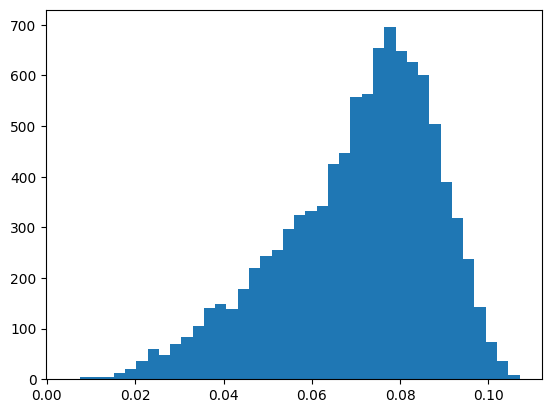

(array([  1.,   3.,   4.,   5.,   9.,  18.,  39.,  39.,  64.,  66.,  90.,
        100., 149., 208., 215., 254., 290., 320., 352., 449., 430., 441.,
        520., 572., 564., 554., 578., 629., 565., 549., 484., 406., 335.,
        295., 177., 113.,  69.,  31.,   9.,   4.]),
 array([-0.09617656, -0.07648925, -0.05680195, -0.03711464, -0.01742734,
         0.00225997,  0.02194728,  0.04163458,  0.06132189,  0.08100919,
         0.1006965 ,  0.1203838 ,  0.14007111,  0.15975841,  0.17944572,
         0.19913302,  0.21882033,  0.23850763,  0.25819494,  0.27788224,
         0.29756955,  0.31725686,  0.33694416,  0.35663147,  0.37631877,
         0.39600608,  0.41569338,  0.43538069,  0.45506799,  0.4747553 ,
         0.4944426 ,  0.51412991,  0.53381721,  0.55350452,  0.57319182,
         0.59287913,  0.61256644,  0.63225374,  0.65194105,  0.67162835,
         0.69131566]),
 <BarContainer object of 40 artists>)

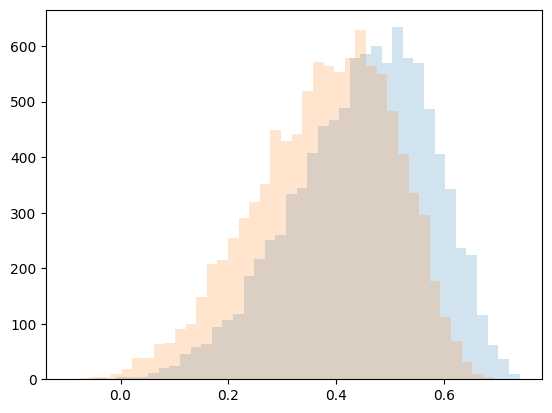

In [45]:

plt.hist(diff_returns, bins=40)
plt.show()

plt.hist(X_t_metrics[:, 0], bins=40, alpha=0.2)
plt.hist(s_t_metrics[:, 0], bins=40, alpha=0.2)